In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/MyDrive/SLIIT/Research Project/

/content/gdrive/MyDrive/SLIIT/Research Project


In [3]:
#import relevant libraries
import numpy as np
import pandas as pd

#import the csv file to extract data
df=pd.read_csv('GDP.csv')
df=df.dropna() #drop null values
print('Shape of data',df.shape)
df.info()
df.head()

Shape of data (62, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   YEAR     62 non-null     int64 
 1   GDP-LKR  62 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


,YEAR,GDP-LKR
0,1960,"6,331"
1,1961,"6,353"
2,1962,"6,549"
3,1963,"6,849"
4,1964,"7,326"


We have to convert the 'Net Credit granted to the Government (NCG)' column's datatype into float.

In [4]:
#import relevant libraries
#import numpy as np
#import pandas as pd

#import the csv file to extract data
#df=pd.read_csv('Money printing data.csv')
#df=df.dropna() #drop null values
#print('Shape of data',df.shape)

# define a function to remove comma and convert to float
def remove_comma_and_convert_to_float(s):
    s = s.replace(',', '')
    f = float(s)
    return f


#apply the function to the entire column
df['GDP-LKR'] = df['GDP-LKR'].apply(remove_comma_and_convert_to_float)

#drop duplicates
dup_sum=df.duplicated(subset='YEAR').sum()
print(dup_sum)

0


No duplicates available.

In [6]:
df.shape

(62, 2)

Now the dataset is preprocessed.

Now we have to test whether the data set is stationary or not. Use Augmented Dick-fuller (ADF) for that.

    null hypotheis : the series is non-stationary
    alternative hypothesis : the series is stationary


In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['GDP-LKR'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.486494
p-value: 0.984457


As the p-value is greater than 0.05, the null hypothesis cannot be rejected at a significant level of 95%. So the tme series is not stationary.

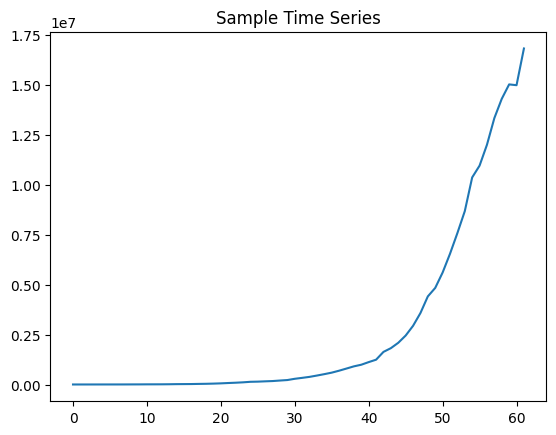

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# plot the time series
plt.plot(df['GDP-LKR'])
plt.title('Sample Time Series')
plt.show()

Lets check the seasonality of the time series.

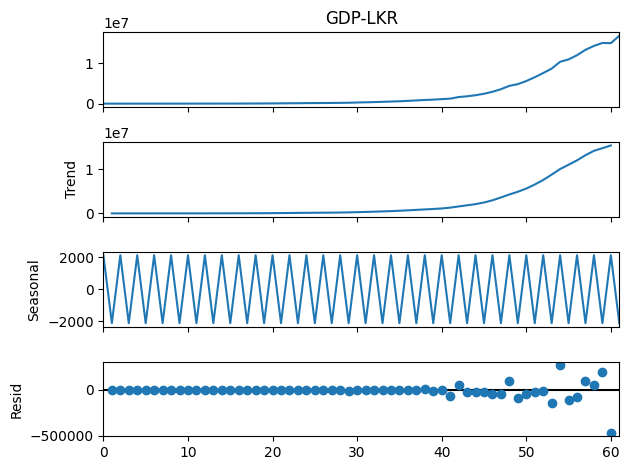

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition using moving averages
decomposition = seasonal_decompose(df['GDP-LKR'], model='additive', period=2)

# Plot the seasonal decomposition
fig = decomposition.plot()

No seasonality here.

As the time series is non-stationary, let us differentiate it.

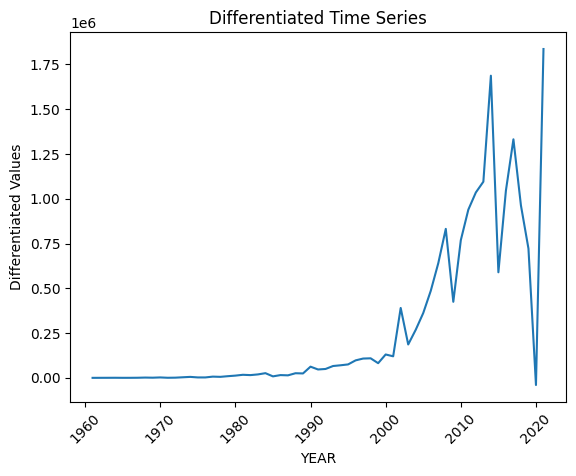

In [6]:
df['diff'] = df['GDP-LKR'].diff()

# drop the first row (since it will have NaN value after differencing)
df.dropna(inplace=True)

# Plot the differentiated values
plt.plot(df['YEAR'], df['diff'])
plt.xlabel('YEAR')
plt.ylabel('Differentiated Values')
plt.title('Differentiated Time Series')
plt.xticks(rotation=45)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['diff'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.876025
p-value: 0.002219


Now the time series is stationary as the p-value is less than 0.05.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 1 to 61
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     61 non-null     int64  
 1   GDP-LKR  61 non-null     float64
 2   diff     61 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [21]:
df.head()

,YEAR,GDP-LKR,diff
1,1961,6353.0,22.0
2,1962,6549.0,196.0
3,1963,6849.0,300.0
4,1964,7326.0,477.0
5,1965,7499.0,173.0


Lets do the ADF test & check the stationarity again.

Now lets try to idetify p,d,q values of the ARIMA model using pacf, acf plots.

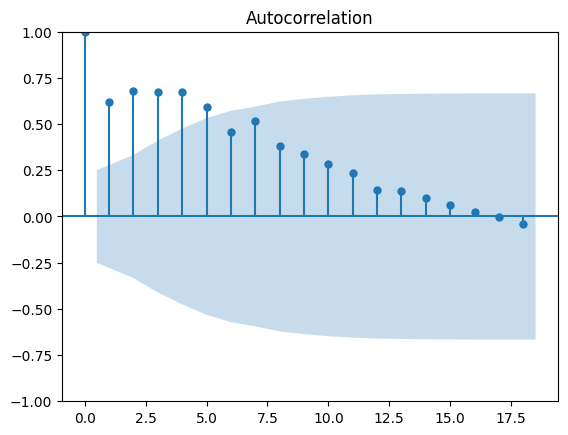

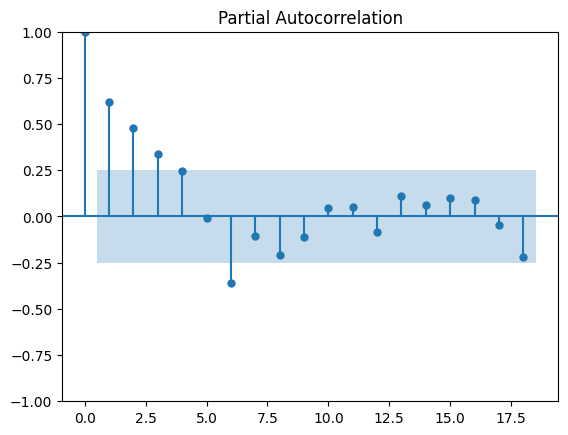

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(df['diff'])
plot_pacf(df['diff'])
plt.show()


according to the plots, p=4, q=5, and as the time series is differentiated once, d=1.

Lets use some other methods to determine SARIMA parameters.

In [24]:
#install pmdarima
!pip install pmdarima


from pmdarima.arima import auto_arima

# Perform grid search
model = auto_arima(df['diff'], seasonal=False, suppress_warnings=True)

# Print the best parameters found
print("Best SARIMA parameters:", model.order, model.seasonal_order)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.0 MB/s eta 0:00:00
Best SARIMA parameters: (3, 1, 2) (0, 0, 0, 0)


Lets fit the model based on the determined p,d,q values.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

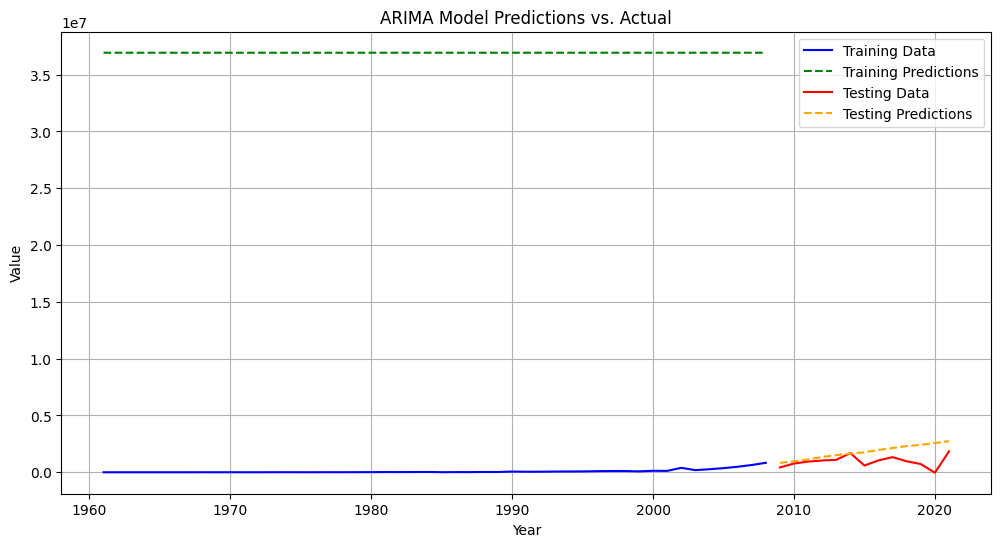

Training RMSE: 36832442.16149502
Testing RMSE: 1097895.4221274585


In [7]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

# Set 'YEAR' column as the index
df.set_index('YEAR', inplace=True)

# Split the data into train and test sets
train, test = train_test_split(df['diff'], test_size=0.2, shuffle=False)

# Fit the ARIMA model
model = sm.tsa.ARIMA(train, order=(4, 1, 5))
fitted_model = model.fit()

# Save the ARIMA model to a pickle file
with open('GDP.pkl', 'wb') as file:
    pickle.dump(fitted_model, file)

# Predict training data
train_predictions = fitted_model.predict(start=train.index[0], end=train.index[-1], dynamic=False, typ='levels')

# Predict testing data
test_predictions = fitted_model.forecast(steps=len(test))

# Calculate RMSE for training data
train_rmse = sqrt(mean_squared_error(train[:], train_predictions))

# Calculate RMSE for testing data
test_rmse = sqrt(mean_squared_error(test, test_predictions))

# Plot training and testing data along with predictions
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(train_predictions, label='Training Predictions', linestyle='dashed', color='green')
plt.plot(test.index, test, label='Testing Data', color='red')
plt.plot(test.index, test_predictions, label='Testing Predictions', linestyle='dashed', color='orange')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions vs. Actual')
plt.legend()
plt.grid(True)
plt.show()

print('Training RMSE:', train_rmse)
print('Testing RMSE:', test_rmse)


In [ ]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 diff   No. Observations:                  258
Model:             SARIMAX(8, 2, 3)x(1, 2, [1], 12)   Log Likelihood               -2837.199
Date:                              Mon, 21 Aug 2023   AIC                           5702.398
Time:                                      07:44:58   BIC                           5750.652
Sample:                                  02-01-1996   HQIC                          5721.859
                                       - 07-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7325      3.094     -0.560      0.576      -7.797       4.332
ar.L2         -1.2917      2.241     -0.576      0.564      -5.683       3.100
ar.L3         -0.8429      1.710     -0.493      0.622      -4.194       2.508
ar.L4         -0.5445      1.187     -0.459      0.646      -2.870       1.781
ar.L5         -0.4303      1.072     -0.401      0.688      -2.532       1.671
ar.L6         -0.3793      0.885     -0.429      0.668      -2.114       1.355
ar.L7         -0.2651      0.743     -0.357      0.721      -1.721       1.190
ar.L8         -0.0726      0.273     -0.266      0.790      -0.607       0.462
ma.L1         -0.9428      3.159     -0.298      0.765      -7.134       5.248
ma.L2         -0.9483      6.145     -0.154      0.877     -12.991      11.095
ma.L3          0.9082      3.037      0.299      0.765      -5.044       6.860
ar.S.L12      -0.5068      0.224     -2.258      0.024      -0.947      -0.067
ma.S.L12      -0.8019      0.288     -2.788      0.005      -1.366      -0.238
sigma2      5.144e+09   1.84e-08    2.8e+17      0.000    5.14e+09    5.14e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               153.28
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              55.48   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.83e+33. Standard errors may be unstable.
"""

Lets predict the testing data & check the model.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Month'>

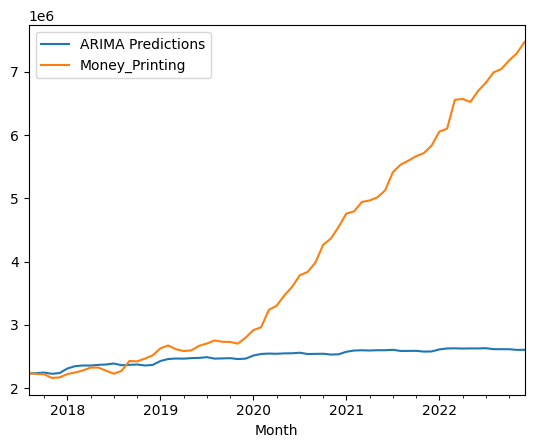

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=fitted_model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test.plot(legend=True)

Lets measure the accuracy of the model.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test.mean()
rmse=sqrt(mean_squared_error(pred,test))
print(rmse)

2210699.692211213


Lets predict values for next 5 years.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

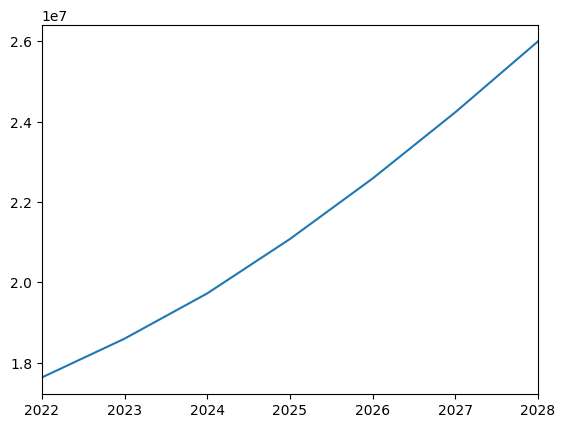

In [8]:
import pandas as pd

start_date = '2022'
end_date = '2029'

# Generate monthly date range
date_range = pd.date_range(start=start_date, end=end_date, freq='Y')

# Predict future values
predictions_future = fitted_model.get_forecast(steps=len(date_range))
predicted_values_diff = predictions_future.predicted_mean

# Reverse the differencing process
base_value = df['GDP-LKR'].iloc[-1]  # Replace 'diff' with the appropriate column name
predicted_values_cumsum = predicted_values_diff.cumsum()
predicted_values_actual = base_value + predicted_values_cumsum

# Set the index as the date range
predicted_values_actual.index = date_range

# Save the predictions to a CSV file
predicted_values_actual.to_csv('GDP_predictions.csv')

# Plot the predicted values
predicted_values_actual.plot()
